# Modelos usando el algoritmo de arboles de decisión

### Importación de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

from matplotlib import pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV

import informe
import preprocessing

from sklearn.metrics import classification_report

from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

### Llamado a funciones de preprocesamiento

#### Conversión de variables
- Hay que convertir todos los features categóricos a númericos. Para variables categóricas se usarán Dummy Variables y para ordinales OrdinalEncoder.

In [3]:
df = preprocessing.remove_irrelevant_features(df)
df = preprocessing.missings_treatment(df)
df = preprocessing.one_hot_encodding(df)
X = df.drop('tiene_alto_valor_adquisitivo', axis='columns')

# Se separa el dataset en entrenamiento y holdout
y = df.tiene_alto_valor_adquisitivo
X_train, X_val, y_train, y_val = preprocessing.dataset_split(X, y)

# Se separa el dataset de validacion en 2 partes, X_val para seleccionar el mejor modelo de knn y X_holdout para el test final
X_val, X_holdout, y_val, y_holdout = preprocessing.dataset_split(X_val, y_val, 0.2)

### Modelos

#### Modelo 1
- Se usan todos los features para entrenar el modelo

In [4]:
modelo1 = tree.DecisionTreeClassifier(random_state=117)
params = {'max_depth': np.arange(1, 9), 'min_samples_leaf': np.arange(1, 16), 'criterion': ['gini', 'entropy']}
metricas = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

rscv = RandomizedSearchCV(
    modelo1, params, n_iter=60, scoring=metricas, n_jobs=None, cv=5, return_train_score=True, refit = 'roc_auc'
).fit(X_train, y_train)

informe.imprimir_metricas(rscv, X_val, y_val, nombre = "modelo 1")

modelo1 = rscv.best_estimator_

/home/sebastian/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sebastian/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sebastian/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sebastian/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: Un

Resultados modelo 1
    Mejores hiperparámetros: {'min_samples_leaf': 12, 'max_depth': 8, 'criterion': 'gini'}
    Métrica AUC ROC: 0.90
    Otras metricas:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5933
           1       0.79      0.53      0.64      1882

    accuracy                           0.85      7815
   macro avg       0.83      0.74      0.77      7815
weighted avg       0.85      0.85      0.84      7815



#### Modelo 2
- se seleccionan los features mas relevantes haciendo embedding, el resto se descartan 

In [5]:
X_train_c = X_train.copy()

features_relevantes = preprocessing.embedded(X_train_c, y_train, min_importance=0.05).columns
X_train_reducido = X_train[features_relevantes]
X_val_reducido = X_val[features_relevantes]
X_holdout_reducido = X_holdout[features_relevantes]

In [6]:
modelo2 = tree.DecisionTreeClassifier(random_state=117)
params = {'max_depth': np.arange(2, 9), 'min_samples_leaf': np.arange(2, 16), 'criterion': ['gini', 'entropy']}

metricas = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

rscv = RandomizedSearchCV(
    modelo2, params, n_iter=60, scoring=metricas, n_jobs=None, cv=5, return_train_score=True, refit = 'roc_auc'
).fit(X_train_reducido, y_train)

informe.imprimir_metricas(rscv, X_val_reducido, y_val, nombre = "modelo 2")

modelo2 = rscv.best_estimator_

Resultados modelo 2
    Mejores hiperparámetros: {'min_samples_leaf': 6, 'max_depth': 8, 'criterion': 'gini'}
    Métrica AUC ROC: 0.90
    Otras metricas:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5933
           1       0.80      0.53      0.64      1882

    accuracy                           0.86      7815
   macro avg       0.83      0.75      0.77      7815
weighted avg       0.85      0.86      0.84      7815



#### Modelo 3
- Con los features mas relevantes se arma un ensamble usando la estrategia bagging con la cual se construyen multiples estimadores para definir las predicciones

In [7]:
modelo3 = BaggingClassifier(base_estimator=DecisionTreeClassifier())

params = {'base_estimator__max_depth': np.arange(2, 9), 'base_estimator__min_samples_leaf': np.arange(2, 16), 'base_estimator__criterion': ['gini', 'entropy']}
metricas = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

rscv = RandomizedSearchCV(
    modelo3, params, n_iter=60, scoring=metricas, n_jobs=None, cv=5, return_train_score=True, refit = 'roc_auc'
).fit(X_train_reducido, y_train)

informe.imprimir_metricas(rscv, X_val_reducido, y_val, nombre = "modelo 3")

modelo3 = rscv.best_estimator_

Resultados modelo 3
    Mejores hiperparámetros: {'base_estimator__min_samples_leaf': 2, 'base_estimator__max_depth': 8, 'base_estimator__criterion': 'gini'}
    Métrica AUC ROC: 0.91
    Otras metricas:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5933
           1       0.80      0.53      0.64      1882

    accuracy                           0.86      7815
   macro avg       0.83      0.75      0.77      7815
weighted avg       0.85      0.86      0.84      7815



#### Modelo 4
- Análogo al modelo 3, pero usando un ensamble de tipo random forest, el cual es más adecuada para ensamble de arboles

In [8]:
modelo4 = RandomForestClassifier(max_depth=20)

params = {'max_depth': np.arange(2, 9), 'min_samples_leaf': np.arange(2, 16), 'criterion': ['gini', 'entropy']}
metricas = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

rscv = RandomizedSearchCV(
    modelo4, params, n_iter=60, scoring=metricas, n_jobs=None, cv=5, return_train_score=True, refit = 'roc_auc'
).fit(X_train_reducido, y_train)

informe.imprimir_metricas(rscv, X_val_reducido, y_val, nombre = "modelo 4")

modelo4 = rscv.best_estimator_

Resultados modelo 4
    Mejores hiperparámetros: {'min_samples_leaf': 4, 'max_depth': 8, 'criterion': 'gini'}
    Métrica AUC ROC: 0.91
    Otras metricas:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      5933
           1       0.80      0.53      0.64      1882

    accuracy                           0.86      7815
   macro avg       0.83      0.75      0.77      7815
weighted avg       0.85      0.86      0.84      7815



### Conclusión
      En base a la metrica AUC-ROC, se ve que los 4 modelos performan practicamente igual. Siguiendo el principio de Navaja de Ockham, elegimos el modelo más simple, que en este caso es el modelo 2, ya que es el que usa menos features. Es más interpretable, implica menos procesamiento y el rendimiento es muy similar.
      
### Informe del modelo 2 usando los datos del test_holdout

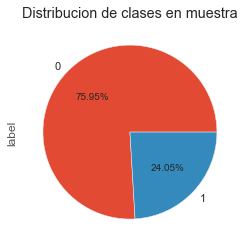

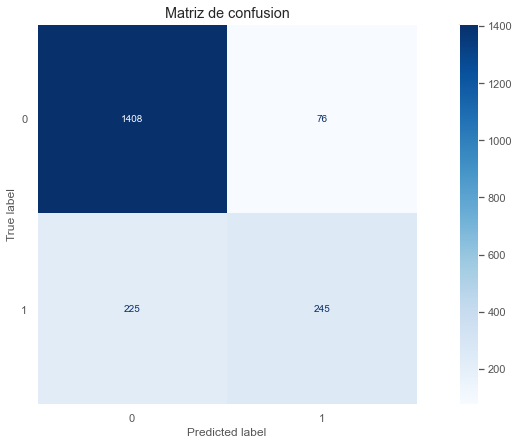

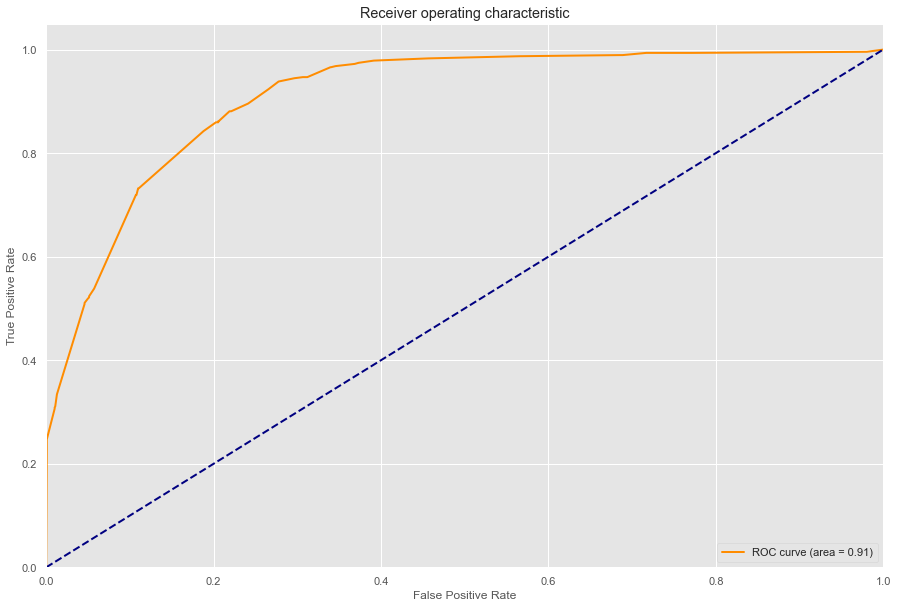

Métricas:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1484
           1       0.76      0.52      0.62       470

    accuracy                           0.85      1954
   macro avg       0.81      0.74      0.76      1954
weighted avg       0.84      0.85      0.84      1954



In [13]:
informe.imprimir_informe(modelo2, X_holdout_reducido, y_holdout)

### Conclusiones de las métricas observadas de los datos de hold_out

- accuracy:

        El modelo clasifica los datos de forma correcta en aproximadamente un 85%, viendo la distribucion de clases de la muestra se observa que los encuestados de bajos ingresos son la clase mayoritaria con una proporción de aproximadamente 76%. Por lo tanto el modelo es mejor predictor que devolver siempre cero.
    
    
- precisión:

        El porcentaje de predicciones de bajos ingresos que realmente lo eran fue de aproximadamente 86% y el de predicciones de altos ingresos que realmente lo eran fue del 76% 


- recall:

        Los bajos ingresos reales detectados fueron aproximadamente del 95%, y los altos ingresos reales detectados fueron del 52%. Viendo este resultado en conjunto con la precisión, se entiende que el modelo es bueno prediciendo los bajos ingresos pero prediciendo los altos ingresos tiene un comportamiento comparable al aleatorio, ya que aproximadamente la mitad de las veces los detecta y la otra mitad no. 
       
       
- matriz de confusión:

        Se puede ver que las predicciones mayoritarias caen en la diagonal principal, lo cual es una buena caracteristica de una matriz de confusión. Sin embargo para los 1's (altos ingresos), las dos columnas estan demasiado balanceadas, lo cual ya se sabia ya que en el resultado de recall para los altos ingresos era aproximadamente del 50%.
        Aproximadamente el 85% de las instancias se encuentran en la diagonal principal, (lo cual ya sabiamos por el accuracy del 85%)
        
        
- AUC ROC:

        Esta métrica indica que el modelo es bueno distinguiendo clases con un score de 0.91. Este valor será utilizado para decidir sobre la elección de este modelo.


# Final test

In [14]:
df_test = informe.get_df_test()

#preprocesamiento
df_test = preprocessing.remove_irrelevant_features(df_test)
df_test = preprocessing.missings_treatment(df_test)
df_test = preprocessing.one_hot_encodding(df_test)
df_test = df_test[features_relevantes]

y_pred = modelo2.predict(df_test)
informe.save_pred(y_pred, 'arbol')